<a href="https://colab.research.google.com/github/fv-123/LSTM-MLP-MeanVariance-project/blob/main/risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MC_sampling not really good yet

Step 1/145: Predicting day 613
Early stopping at epoch 40
Step 2/145: Predicting day 614
Early stopping at epoch 4
Step 3/145: Predicting day 615
Early stopping at epoch 8
Step 4/145: Predicting day 616
Early stopping at epoch 9
Step 5/145: Predicting day 617
Early stopping at epoch 6
Step 6/145: Predicting day 618
Early stopping at epoch 4
Step 7/145: Predicting day 619
Early stopping at epoch 4
Step 8/145: Predicting day 620
Early stopping at epoch 7
Step 9/145: Predicting day 621
Early stopping at epoch 8
Step 10/145: Predicting day 622
Early stopping at epoch 11
Step 11/145: Predicting day 623
Early stopping at epoch 4
Step 12/145: Predicting day 624
Early stopping at epoch 14
Step 13/145: Predicting day 625
Early stopping at epoch 4
Step 14/145: Predicting day 626
Early stopping at epoch 5
Step 15/145: Predicting day 627
Early stopping at epoch 4
Step 16/145: Predicting day 628
Early stopping at epoch 8
Step 17/145: Predicting day 629
Early stopping at epoch 9
Step 18/145: Predict

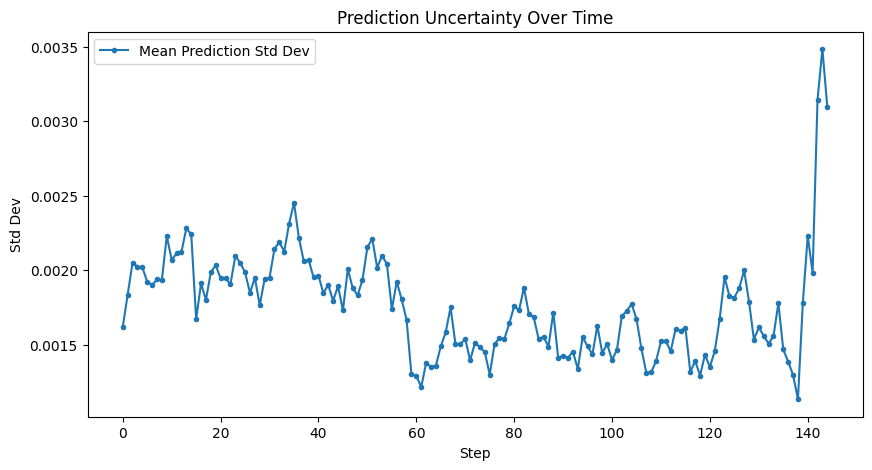

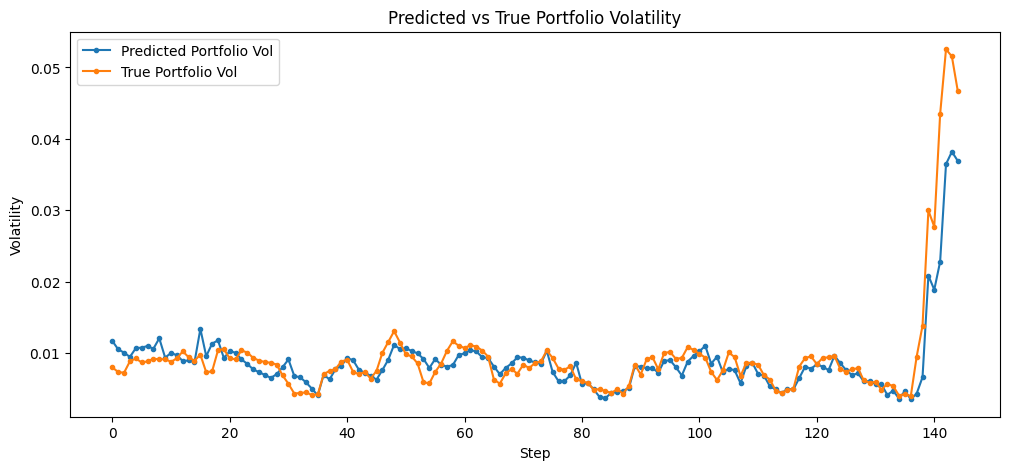

Risk model results saved to 'risk_model_results.pkl'


In [ ]:
#%%
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pickle
#%%
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#%%
# --- Data Loading and Preparation ---
df = pd.read_csv("combined_stock_data_wide.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.dropna(inplace=True)

# Identify close price and volume columns
close_cols = [c for c in df.columns if c.endswith("_Close") and "Adj" not in c]
volume_cols = [c for c in df.columns if c.endswith("_Volume")]
asset_count = len(close_cols)
#%%
# Hyperparameters
horizon = 7  # Prediction horizon (days)
sequence_length = 35  # Input sequence length
initial_train_frac = 0.80  # Initial training data fraction
batch_size = 64  # Batch size for training
num_epochs = 50  # Max epochs per retraining
patience = 3  # Early stopping patience
learning_rate = 3e-4  # Optimizer learning rate
hidden_size = 128  # LSTM hidden units
num_layers = 2  # Number of LSTM layers
dropout_prob = 0.2  # Dropout probability
mc_samples = 90  # Monte Carlo samples for uncertainty
lambda_dir = 0.6  # Directional loss weight
#%%
# Compute log returns and realized volatility
close_df = df[close_cols]
log_returns = np.log(close_df / close_df.shift(1))
realized_vol = log_returns.rolling(window=horizon, min_periods=horizon).std().shift(-horizon)
#%%
# Feature engineering
past_std_ewm = log_returns.ewm(span=horizon, adjust=False).std().add_suffix("_ewm")
disc_log_ret = log_returns.add_suffix("_logret")
liq = (np.log1p(df[volume_cols]).diff().ewm(span=horizon, adjust=False).mean()
       .rename(columns=lambda c: c.replace("_Volume", "_liq")))
#%%
# Align data by date
common_idx = (past_std_ewm.index.intersection(disc_log_ret.index)
              .intersection(liq.index).intersection(realized_vol.index))
past_std_ewm = past_std_ewm.loc[common_idx]
disc_log_ret = disc_log_ret.loc[common_idx]
liq = liq.loc[common_idx]
realized_vol = realized_vol.loc[common_idx]
log_returns = log_returns.loc[common_idx]

# Combine features and targets
features = pd.concat([past_std_ewm, disc_log_ret, liq], axis=1)
targets = realized_vol.copy()
combined = pd.concat([features, targets], axis=1).dropna()
features = combined[features.columns].reset_index(drop=True)
targets = combined[targets.columns].reset_index(drop=True)
#%%
# Create sequences for LSTM
def create_sequences(X_df, Y_df, seq_len):
    Xs, Ys = [], []
    for i in range(len(X_df) - seq_len):
        Xs.append(X_df.iloc[i:i + seq_len].values)
        Ys.append(Y_df.iloc[i + seq_len - 1].values)
    return np.array(Xs), np.array(Ys)

X_all, y_all = create_sequences(features, targets, sequence_length)
N = len(X_all)
assert N > 0, "No sequences generated!"

#%%
# --- LSTM Model with Monte Carlo Dropout ---
class VolLSTM_MC(nn.Module):
    def __init__(self, in_feats, hid, nlayers, out_feats, drop):
        super().__init__()
        self.lstm = nn.LSTM(in_feats, hid, nlayers, batch_first=True, dropout=drop)
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(hid, out_feats)

    def forward(self, x):
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        h = self.dropout(h)
        h = torch.relu(h)
        return self.fc(h)

# Initialize model
model = VolLSTM_MC(X_all.shape[2], hidden_size, num_layers, asset_count, dropout_prob).to(device)
#%%
# --- Walk-Forward Simulation ---
initial_train_size = int(initial_train_frac * N)
n_steps = N - initial_train_size - horizon
results = []

for t in range(n_steps):
    print(f"Step {t + 1}/{n_steps}: Predicting day {initial_train_size + t + horizon}")

    set_seed(42 + t)  # Vary seed for MC dropout

    train_end_idx = initial_train_size + t
    pred_idx = train_end_idx

    # Training data
    X_train = X_all[:train_end_idx]
    y_train = y_all[:train_end_idx]

    # Scale data
    scaler_X = StandardScaler().fit(X_train.reshape(-1, X_all.shape[2]))
    scaler_y = StandardScaler().fit(y_train)
    X_train_scaled = scaler_X.transform(X_train.reshape(-1, X_all.shape[2])).reshape(-1, sequence_length,
                                                                                     X_all.shape[2])
    y_train_scaled = scaler_y.transform(y_train)

    # DataLoader
    train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                  torch.tensor(y_train_scaled, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Optimizer and early stopping
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_loss = float('inf')
    wait = 0
    best_model_state = model.state_dict()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            mse_loss = nn.MSELoss()(y_pred, y_batch)
            true_dir = torch.sign(y_batch[:, 1:] - y_batch[:, :-1])
            pred_dir = torch.sign(y_pred[:, 1:] - y_batch[:, :-1])
            bce_loss = nn.BCEWithLogitsLoss()(pred_dir, (true_dir > 0).float())
            loss = mse_loss + lambda_dir * bce_loss
            loss.backward()
            optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            wait = 0
            best_model_state = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    model.load_state_dict(best_model_state)

    # Prediction with uncertainty
    X_pred = X_all[pred_idx:pred_idx + 1]
    y_true = y_all[pred_idx:pred_idx + 1]
    X_pred_scaled = scaler_X.transform(X_pred.reshape(-1, X_all.shape[2])).reshape(1, sequence_length, X_all.shape[2])

    def enable_dropout(m):
        for layer in m.modules():
            if isinstance(layer, nn.Dropout):
                layer.train()

    model.eval()
    enable_dropout(model)

    mc_predictions = []
    with torch.no_grad():
        X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32).to(device)
        for _ in range(mc_samples):
            mc_predictions.append(model(X_pred_tensor).cpu().numpy())
    mc_predictions = np.stack(mc_predictions, axis=0)

    # Back to pre-scaled
    y_pred_mean = scaler_y.inverse_transform(mc_predictions.mean(axis=0))
    y_pred_std = mc_predictions.std(axis=0) * scaler_y.scale_

    # Metrics
    mae = mean_absolute_error(y_true, y_pred_mean, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_mean, multioutput='raw_values'))

    # Directional accuracy
    dir_acc = None
    if pred_idx >= horizon:
        y_true_current = y_all[pred_idx - horizon]
        y_true_future = y_true[0]
        pred_direction = np.sign(y_pred_mean[0] - y_true_current)
        true_direction = np.sign(y_true_future - y_true_current)
        dir_acc = (true_direction == pred_direction).astype(float)

    # Uncertainty-based portfolio allocation
    weights = 1 / (y_pred_std[0] + 1e-6)
    weights /= weights.sum()

    # Portfolio volatility with corrected correlation matrix
    # Step 1: compute daily log returns (already defined earlier)
    #    log_returns = np.log(close_df / close_df.shift(1))

    # Step 2: aggregate into 7-day log returns
    log7 = log_returns.rolling(window=horizon).sum().dropna()

    # Step 3: restrict to the data up to the prediction point
    log7_window = log7.iloc[: pred_idx + sequence_length]

    # Step 4: convert those 7-day log returns to 7-day simple returns
    window_data = np.exp(log7_window) - 1

    # Step 5: compute exponentially weighted covariance on 7-day simple returns
    ewm_cov = window_data.ewm(span=horizon, adjust=False).cov()

    # Step 6: extract the latest 7-day covariance matrix
    last_timestamp = window_data.index[-1]
    cov_matrix = (
        ewm_cov
          .loc[last_timestamp]
          .values
          .reshape(asset_count, asset_count)
    )

    # Step 7: build correlation matrix
    variances = np.diag(cov_matrix)
    stds      = np.sqrt(variances)
    corr_matrix = cov_matrix / np.outer(stds, stds)
    corr_matrix = np.nan_to_num(corr_matrix, nan=0, posinf=1, neginf=-1)
    corr_matrix = np.clip(corr_matrix, -1, 1)

    # Step 8: reconstruct predicted and true covariance in simple-return space
    D_pred   = np.diag(y_pred_mean[0])  # predicted 7-day simple-return stds
    cov_pred = D_pred @ corr_matrix @ D_pred
    vol_pred_port = np.sqrt(weights @ cov_pred @ weights)

    D_true   = np.diag(y_true[0])       # actual 7-day simple-return stds
    cov_true = D_true @ corr_matrix @ D_true
    vol_true_port = np.sqrt(weights @ cov_true @ weights)


    # Store results with covariance
    results.append({
        'step': t,
        'date': log_returns.index[pred_idx + sequence_length - 1],
        'mae': mae,
        'rmse': rmse,
        'dir_acc': dir_acc,
        'vol_pred_port': vol_pred_port,
        'vol_true_port': vol_true_port,
        'y_pred_std': y_pred_std,
        'weights': weights,
        'cov_pred': cov_pred  # Added covariance matrix
    })
#%%
# --- Summary and Visualizations ---
print("\nWalk-Forward Validation Summary:")
mae_all = np.array([res['mae'] for res in results])
rmse_all = np.array([res['rmse'] for res in results])
dir_acc_all = np.array([res['dir_acc'] for res in results if res['dir_acc'] is not None])
vol_pred_port_all = [res['vol_pred_port'] for res in results]
vol_true_port_all = [res['vol_true_port'] for res in results]
#%%
# Average metrics
mae_mean = mae_all.mean(axis=0)
mae_std = mae_all.std(axis=0)
rmse_mean = rmse_all.mean(axis=0)
rmse_std = rmse_all.std(axis=0)
dir_acc_mean = dir_acc_all.mean(axis=0)

# Compute standard error for DirAcc with Binomial approximation
n_steps_dir_acc = len(dir_acc_all)
dir_acc_se = np.sqrt(dir_acc_mean * (1 - dir_acc_mean) / n_steps_dir_acc)

# Convert to percentage for reporting
dir_acc_mean = dir_acc_mean * 100
dir_acc_se = dir_acc_se * 100

# Portfolio volatility
vol_pred_port_mean = np.mean(vol_pred_port_all)
vol_true_port_mean = np.mean(vol_true_port_all)

print("\nOverall Performance Across Assets:")
for i, col in enumerate(close_cols):
    print(f"{col}: MAE={mae_mean[i]:.4f} ± {mae_std[i]:.4f}, "
          f"RMSE={rmse_mean[i]:.4f} ± {rmse_std[i]:.4f}, "
          f"DirAcc={dir_acc_mean[i]:.1f}% ± {dir_acc_se[i]:.1f}%")
print(f"\nPortfolio Volatility: Predicted={vol_pred_port_mean:.4f}, True={vol_true_port_mean:.4f}")
#%%
# Visualizations
plt.figure(figsize=(10, 5))
plt.plot([r['y_pred_std'].mean() for r in results], label='Mean Prediction Std Dev', marker='.')
plt.title('Prediction Uncertainty Over Time')
plt.xlabel('Step')
plt.ylabel('Std Dev')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(vol_pred_port_all, label='Predicted Portfolio Vol', marker='.')
plt.plot(vol_true_port_all, label='True Portfolio Vol', marker='.')
plt.title('Predicted vs True Portfolio Volatility')
plt.xlabel('Step')
plt.ylabel('Volatility')
plt.legend()
plt.show()
#%%
# Save results without removing y_pred_std
with open('risk_model_results.pkl', 'wb') as f:
    pickle.dump({'results': results, 'close_cols': close_cols, 'log_returns': log_returns}, f)
print("Risk model results saved to 'risk_model_results.pkl'")